# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
# Try loading one file
## df = pd.read_parquet('2023-1.parquet')
## df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [5]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import time
import os

# Select the folder having data files
os.chdir('trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
date_sample = pd.DataFrame()

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)
        print(file_path)
        # Reading the current file
        start = time.time()
        df = pd.read_parquet(file_path)
        #print(df.shape)
        # Add date and hour column from trip start date
        df["tpep_pickup_date"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.date
        df["tpep_pickup_hour"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.hour

        # Take unique values for date to iterate over
        dates = df["tpep_pickup_date"].unique()
        #print(dates)
        for date in dates:
        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
            print(f"Processing for {date} ")
            sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        
            # Iterate through each hour of the selected date
            hours = df["tpep_pickup_hour"].unique()
            #print(hours)
            for hour in hours:
                hour_data = pd.DataFrame()
                hour_data = df[(df["tpep_pickup_date"] == date) & (df["tpep_pickup_hour"] == hour)]
                # Sample 5% of the hourly data randomly                                
                sample = hour_data.sample(frac = 0.05, random_state = 42)
                # add data of this hour to the dataframe
                sampled_data = pd.concat([sampled_data, sample])
                #print(sampled_data.shape)
        # Concatenate the sampled data of all the dates to a single dataframe
            date_sample = pd.concat([date_sample, sampled_data])
            #print(date_sample.shape)
        #df = # we initialised this empty DF earlier
        end = time.time()
        print(f"Total runtime of the program is {end - start} seconds")
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

C:\Users\Sagar\AIML Module Learning\EDA - Assignment (NYC Taxi)\Starter Notebook - EDA NYC Taxi\trip_records\2023-1.parquet
Processing for 2023-01-01 
Processing for 2022-12-31 
Processing for 2022-10-24 
Processing for 2022-10-25 
Processing for 2023-01-02 
Processing for 2023-01-03 
Processing for 2008-12-31 
Processing for 2023-01-04 
Processing for 2023-01-05 
Processing for 2023-01-06 
Processing for 2023-01-07 
Processing for 2023-01-08 
Processing for 2023-01-09 
Processing for 2023-01-10 
Processing for 2023-01-11 
Processing for 2023-01-12 
Processing for 2023-01-13 
Processing for 2023-01-14 
Processing for 2023-01-15 
Processing for 2023-01-16 
Processing for 2023-01-17 
Processing for 2023-01-18 
Processing for 2023-01-19 
Processing for 2023-01-20 
Processing for 2023-01-21 
Processing for 2023-01-22 
Processing for 2023-01-23 
Processing for 2023-01-24 
Processing for 2023-01-25 
Processing for 2023-01-26 
Processing for 2023-01-27 
Processing for 2023-01-28 
Processing f

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [8]:
date_sample.shape

(1896400, 22)

In [9]:
# Store the df in csv/parquet
# df.to_parquet('')
date_sample.to_parquet('output.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [47]:
# Load the new data file
df = pd.read_parquet("output.parquet")

In [48]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
428             2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1113            2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
819             2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3192            2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
2995263         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
428               7.74         1.0                  N           138   
1113              1.24         1.0                  N           161   
819               1.44         1.0                  N           237   
3192              0.54         1.0                  N           143   
2995263          19.24         NaN               None            66   

         DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
428               256             2  ...      0.5        0.00           0.0   
1113              237             1  ...      0.5        2.58           0.0   
819               141             2  ...      0.5        0.00           0.0   
3192              142             2  ...      0.5        0.00           0.0   
2995263           107             0  ...      0.5        5.93           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
428                        1.0         41.15                   0.0   
1113                       1.0         15.48                   2.5   
819                        1.0         16.40                   2.5   
3192                       1.0         11.50                   2.5   
2995263                    1.0         35.57                   NaN   

         airport_fee  tpep_pickup_date  tpep_pickup_hour Airport_fee  
428             1.25        2023-01-01                 0         NaN  
1113            0.00        2023-01-01                 0         NaN  
819             0.00        2023-01-01                 0         NaN  
3192            0.00        2023-01-01                 0         NaN  
2995263          NaN        2023-01-01                 0         NaN  

[5 rows x 22 columns]

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1896400 entries, 428 to 2698522
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            fl

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [51]:
# Fix the index and drop any columns that are not needed
df.reset_index(drop=True, inplace=True)
df.head()
# Dropping store_and_fwd_flag Column as it is not required
df.drop(columns=['store_and_fwd_flag'], axis=1, inplace=True)
df.shape

(1896400, 21)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [53]:
# Combine the two airport fee columns
cols = ["airport_fee","Airport_fee"]
df = df.assign(airport_fee=df[cols].sum(1))
df = df.drop(["Airport_fee"],axis=1)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           int64         
 9   fare_amount            float64       
 10  extra                  float64       
 11  mta_tax                float64       
 12  tip_amount             float64       
 13  tolls_amount           float64       
 14  improvement_surcharge  float64       
 15  total_amount           float64       
 16  congestion_surcharge   float64       
 17  airport_fee            float64       
 18  tpep_pickup_date      

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [56]:
# check where values of fare amount are negative
df[df.fare_amount<0]

# There are No records with Negative Fare Amount


Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, tpep_pickup_date, tpep_pickup_hour]
Index: []

Did you notice something different in the `RatecodeID` column for above records?

In [57]:
# Analyse RatecodeID for the negative fare amounts
df.RatecodeID.unique()
# It has NAN values


array([ 1., nan,  2.,  4.,  5., 99.,  3.,  6.])

In [58]:
# Find which columns have negative values
negative_columns = []
for column in df.select_dtypes(include=['float64', 'int64']):
    if (df[column] < 0).any():
        negative_columns.append(column)
        
negative_columns


['extra',
 'mta_tax',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [59]:
# fix these negative values
df = df[~df[['extra','mta_tax','improvement_surcharge','total_amount','congestion_surcharge','airport_fee']].lt(0).any(axis=1)] 
df.head()


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0           7.74         1.0           138           256             2   
1           1.24         1.0           161           237             1   
2           1.44         1.0           237           141             2   
3           0.54         1.0           143           142             2   
4          19.24         NaN            66           107             0   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0        32.40    6.0      0.5        0.00           0.0   
1         7.90    1.0      0.5        2.58           0.0   
2        11.40    1.0      0.5        0.00           0.0   
3         6.50    1.0      0.5        0.00           0.0   
4        25.64    0.0      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN         0.00   

  tpep_pickup_date  tpep_pickup_hour  
0       2023-01-01                 0  
1       2023-01-01                 0  
2       2023-01-01                 0  
3       2023-01-01                 0  
4       2023-01-01                 0

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [62]:
# Find the proportion of missing values in each column
round(df.isna().mean()*100)
# 3% data with passenger_count, RatecodeID, congestion_surcharge with NULL values

VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          3.0
trip_distance            0.0
RatecodeID               3.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     3.0
airport_fee              0.0
tpep_pickup_date         0.0
tpep_pickup_hour         0.0
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [64]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
df[df.passenger_count.isna()] # 64874 rows with Passenger count as NAN

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
4               2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   
15              2  2023-01-01 00:41:50   2023-01-01 01:14:50              NaN   
42              2  2023-01-01 00:37:21   2023-01-01 00:54:18              NaN   
43              2  2023-01-01 00:44:03   2023-01-01 01:13:49              NaN   
46              2  2023-01-01 00:50:55   2023-01-01 01:19:06              NaN   
...           ...                  ...                   ...              ...   
1896313         1  2023-09-30 22:47:00   2023-09-30 22:59:51              NaN   
1896345         2  2023-09-30 22:26:44   2023-09-30 22:39:41              NaN   
1896356         1  2023-09-30 22:07:52   2023-09-30 22:13:26              NaN   
1896368         2  2023-09-30 22:50:39   2023-09-30 22:56:04              NaN   
1896397         2  2023-09-30 22:35:50   2023-09-30 22:43:17              NaN   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
4                19.24         NaN            66           107             0   
15               10.77         NaN           151           106             0   
42                4.52         NaN           114           262             0   
43                9.19         NaN           239           256             0   
46                2.74         NaN            90            48             0   
...                ...         ...           ...           ...           ...   
1896313           0.00         NaN            68           170             0   
1896345           2.32         NaN           239            50             0   
1896356           0.00         NaN           238           238             0   
1896368           0.59         NaN           142            48             0   
1896397           1.38         NaN            50            68             0   

         fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
4              25.64    0.0      0.5        5.93          0.00   
15             45.38    0.0      0.5       11.19          6.55   
42             25.38    0.0      0.5        0.00          0.00   
43             40.00    0.0      0.5        2.20          0.00   
46             18.48    0.0      0.5        3.37          0.00   
...              ...    ...      ...         ...           ...   
1896313        17.91    0.0      0.5        0.00          0.00   
1896345        15.93    0.0      0.5        2.00          0.00   
1896356         7.83    0.0      0.5        0.00          0.00   
1896368        16.32    0.0      0.5        3.70          0.00   
1896397        14.48    0.0      0.5        3.70          0.00   

         improvement_surcharge  total_amount  congestion_surcharge  \
4                          1.0         35.57                   NaN   
15                         1.0         67.12                   NaN   
42                         1.0         29.38                   NaN   
43                         1.0         46.20                   NaN   
46                         1.0         25.85                   NaN   
...                        ...           ...                   ...   
1896313                    1.0         21.91                   NaN   
1896345                    1.0         21.93                   NaN   
1896356                    1.0         11.83                   NaN   
1896368                    1.0         24.02                   NaN   
1896397                    1.0         22.18                   NaN   

         airport_fee tpep_pickup_date  tpep_pickup_hour  
4                0.0       2023-01-01                 0  
15               0.0       2023-01-01                 0  
42               0.0       2023-01-01                 0  
43               0.0       2023-01-01                 0  
46               0.0       2023-01-01                 0  
...              ...              ...               ...  
1896313          0.0       2023-09-

In [65]:
# Replacing NAN values in passenger_count with Median values
median_value = df['passenger_count'].median()
df['passenger_count'].fillna(median_value, inplace=True)

In [66]:
df[df.passenger_count.isna()]
# There is no more NAN values in passenger_count column after replacing with Median values

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, tpep_pickup_date, tpep_pickup_hour]
Index: []

Did you find zeroes in passenger_count? Handle these.

In [69]:
df.passenger_count.value_counts()
# There are 29681 rows in passenger_count with 0 values we need to remove them

# Removing 0 value passenger_count
df = df[df.passenger_count != 0]
df[df.passenger_count.isna()]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, tpep_pickup_date, tpep_pickup_hour]
Index: []

In [70]:
df.shape

(1866640, 20)

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [71]:
# Fix missing values in 'RatecodeID'
df.RatecodeID.isna().sum()
# There are 64874 records with missing values in RatecodeID column

64874

In [72]:
# Replace with Mode
mode_value = df.RatecodeID.mode()[0]
df.RatecodeID.fillna(mode_value, inplace=True)
df.RatecodeID.isna().sum()

0

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [73]:
# handle null values in congestion_surcharge
df.congestion_surcharge.isna().sum()

# There are 64874 rows as Nulls in congestion_surcharge, we need to replace them with Mode

64874

In [74]:
# Replacing Null values in congestion_surcharge with Mode
mode_value = df.congestion_surcharge.mode()[0]
df.congestion_surcharge.fillna(mode_value, inplace=True)
df.congestion_surcharge.isna().sum()

0

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [75]:
# Handle any remaining missing values
df.isna().sum()

# No more missing values

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
tpep_pickup_date         0
tpep_pickup_hour         0
dtype: int64

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [77]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df.describe()


VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.866640e+06                     1866640                     1866640   
mean   1.744619e+00  2023-07-02 23:54:35.156987  2023-07-03 00:12:03.801033   
min    1.000000e+00         2022-12-31 23:51:30         2022-12-31 23:56:06   
25%    1.000000e+00  2023-04-02 18:11:20.500000  2023-04-02 18:29:17.750000   
50%    2.000000e+00         2023-06-27 19:32:38         2023-06-27 19:46:11   
75%    2.000000e+00  2023-10-06 23:37:18.750000  2023-10-06 23:54:43.750000   
max    6.000000e+00         2023-12-31 23:57:51         2024-01-01 20:50:55   
std    4.414960e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.866640e+06   1.866640e+06  1.866640e+06  1.866640e+06   
mean      1.378150e+00   3.875038e+00  1.619864e+00  1.652480e+02   
min       1.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.000000e+00   1.050000e+00  1.000000e+00  1.320000e+02   
50%       1.000000e+00   1.800000e+00  1.000000e+00  1.620000e+02   
75%       1.000000e+00   3.410000e+00  1.000000e+00  2.340000e+02   
max       9.000000e+00   1.263605e+05  9.900000e+01  2.650000e+02   
std       8.699587e-01   1.304351e+02  7.312306e+00  6.400130e+01   

       DOLocationID  payment_type   fare_amount         extra       mta_tax  \
count  1.866640e+06  1.866640e+06  1.866640e+06  1.866640e+06  1.866640e+06   
mean   1.640227e+02  1.162249e+00  1.996235e+01  1.561189e+00  4.953202e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.140000e+02  1.000000e+00  9.300000e+00  0.000000e+00  5.000000e-01   
50%    1.620000e+02  1.000000e+00  1.350000e+01  1.000000e+00  5.000000e-01   
75%    2.340000e+02  1.000000e+00  2.229000e+01  2.500000e+00  5.000000e-01   
max    2.650000e+02  4.000000e+00  1.431635e+05  2.080000e+01  4.000000e+00   
std    6.981914e+01  5.076060e-01  1.063548e+02  1.820560e+00  4.840724e-02   

         tip_amount  tolls_amount  improvement_surcharge  total_amount  \
count  1.866640e+06  1.866640e+06           1.866640e+06  1.866640e+06   
mean   3.555335e+00  5.998000e-01           9.990698e-01  2.903906e+01   
min    0.000000e+00  0.000000e+00           0.000000e+00  0.000000e+00   
25%    1.000000e+00  0.000000e+00           1.000000e+00  1.596000e+01   
50%    2.850000e+00  0.000000e+00           1.000000e+00  2.108000e+01   
75%    4.450000e+00  0.000000e+00           1.000000e+00  3.100000e+01   
max    2.230800e+02  1.430000e+02           1.000000e+00  1.431675e+05   
std    4.056998e+00  2.193114e+00           2.804540e-02  1.072306e+02   

       congestion_surcharge   airport_fee  tpep_pickup_hour  
count          1.866640e+06  1.866640e+06      1.866640e+06  
mean           2.314224e+00  2.689354e-01      1.426855e+01  
min            0.000000e+00  0.000000e+00      0.000000e+00  
25%            2.500000e+00  0.000000e+00      1.100000e+01  
50%            2.500000e+00  0.000000e+00      1.500000e+01  
75%            2.500000e+00  0.000000e+00      1.900000e+01  
max            2.500000e+00  3.500000e+00      2.300000e+01  
std            6.556882e-01  9.022622e-01      5.814620e+00

In [79]:
# Checking Outliers
def check_outlier(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = outliers.shape[0]
    
    print(f"Number of outliers for {column} : {outlier_count}")

for col in df.columns:
    check_outlier(col)

Number of outliers for VendorID : 444
Number of outliers for tpep_pickup_datetime : 0
Number of outliers for tpep_dropoff_datetime : 0
Number of outliers for passenger_count : 424598
Number of outliers for trip_distance : 245971
Number of outliers for RatecodeID : 101088
Number of outliers for PULocationID : 0
Number of outliers for DOLocationID : 0
Number of outliers for payment_type : 397361
Number of outliers for fare_amount : 189812
Number of outliers for extra : 32941
Number of outliers for mta_tax : 17557
Number of outliers for tip_amount : 143307
Number of outliers for tolls_amount : 152213
Number of outliers for improvement_surcharge : 2117
Number of outliers for total_amount : 215189
Number of outliers for congestion_surcharge : 138711
Number of outliers for airport_fee : 159254
Number of outliers for tpep_pickup_date : 0
Number of outliers for tpep_pickup_hour : 0


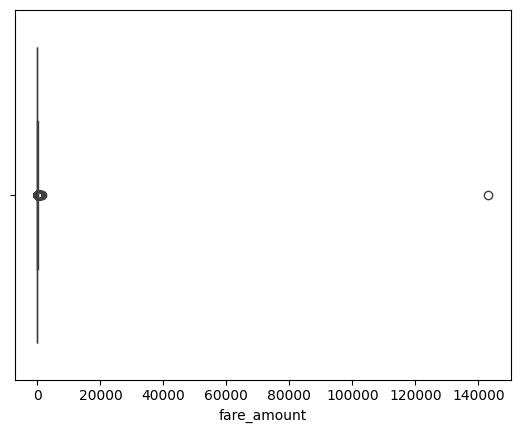

In [84]:
# Plotting a Box Plot to show Outliers
sns.boxplot(x=df["fare_amount"])
plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [85]:
# remove passenger_count > 6
df.passenger_count.value_counts()

passenger_count
1.0    1442042
2.0     277283
3.0      69032
4.0      38532
5.0      23871
6.0      15859
8.0         11
7.0          5
9.0          5
Name: count, dtype: int64

In [86]:
# Remove Passerngers where count is Greater than 6
df = df[df['passenger_count']<=6]

(1866619, 20)

In [88]:
# Continue with outlier handling
df = df[~((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300))]
df = df[~((df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID']))]
df = df[df['trip_distance'] <= 250]
df = df[df['payment_type'] != 0]
df.reset_index(drop=True, inplace=True)
df.shape

(1801639, 20)

In [89]:
# Do any columns need standardising?
for col in df.columns:
    check_outlier(col)

Number of outliers for VendorID : 0
Number of outliers for tpep_pickup_datetime : 0
Number of outliers for tpep_dropoff_datetime : 0
Number of outliers for passenger_count : 424557
Number of outliers for trip_distance : 238666
Number of outliers for RatecodeID : 101010
Number of outliers for PULocationID : 0
Number of outliers for DOLocationID : 0
Number of outliers for payment_type : 332431
Number of outliers for fare_amount : 189395
Number of outliers for extra : 32643
Number of outliers for mta_tax : 16784
Number of outliers for tip_amount : 140152
Number of outliers for tolls_amount : 147054
Number of outliers for improvement_surcharge : 1420
Number of outliers for total_amount : 212556
Number of outliers for congestion_surcharge : 138608
Number of outliers for airport_fee : 159242
Number of outliers for tpep_pickup_date : 0
Number of outliers for tpep_pickup_hour : 0


In [90]:
# Fare greater than 5000
df = df[df['fare_amount'] <= 5000]
# Tip amount is greater than fare amount, with total amount greater than 100
df = df[~(((df['tip_amount']) > (df['fare_amount'])) & (df['total_amount'] > 100 ))]

In [91]:
df.shape

(1801494, 20)

In [92]:
df.describe

<bound method NDFrame.describe of          VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1               2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2               2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3               2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4               1  2023-01-01 00:42:56   2023-01-01 01:16:33              2.0   
...           ...                  ...                   ...              ...   
1801634         2  2023-09-30 22:29:16   2023-09-30 22:37:24              1.0   
1801635         2  2023-09-30 22:28:34   2023-09-30 22:33:41              2.0   
1801636         2  2023-09-30 22:35:58   2023-09-30 22:50:21              1.0   
1801637         2  2023-09-30 22:59:21   2023-09-30 23:10:16              1.0   
1801638         2  2023-09-30 22:03:22   2023-09-30 22:06:26              1

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [93]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'tpep_pickup_date',
 'tpep_pickup_hour']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Categorical
* `tpep_dropoff_datetime`: Categorical
* `passenger_count`: Categorical
* `trip_distance`: Categorical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Categorical 
* `trip_duration`: Categorical


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`: Numerical
* `extra`: Numerical
* `mta_tax`: Numerical
* `tip_amount`: Numerical
* `tolls_amount`: Numerical
* `improvement_surcharge`: Numerical
* `total_amount`: Numerical
* `congestion_surcharge`: Numerical
* `airport_fee`: Numerical

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

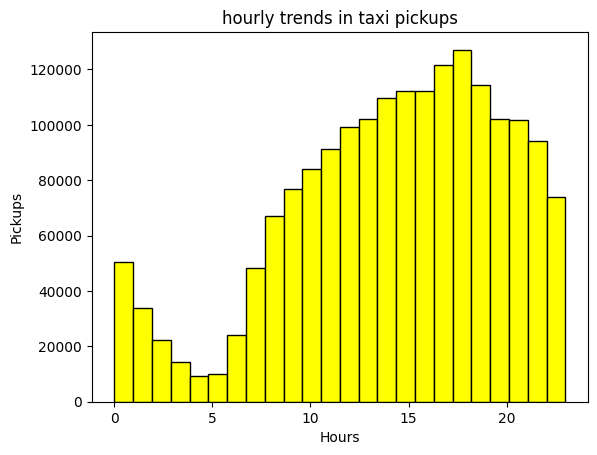

In [108]:
# Find and show the hourly trends in taxi pickups
plt.hist(df.tpep_pickup_hour, bins=24, edgecolor='black',color='yellow')
plt.title('hourly trends in taxi pickups')
plt.xlabel('Hours')
plt.ylabel('Pickups')
plt.show()

# Conclusions from the Histogram: 
# Taxi pickups are lowest between 3 AM t0 6 AM
# Number of pickups increasing gradually throughout the day from 6 AM onwards and reaches the highest between 17th and 19th hours
# There is again decline in pickups after 18th hour

In [ ]:
df['tpep_pickup_dayofweek'] = df.tpep_pickup_datetime.dt.day_name()

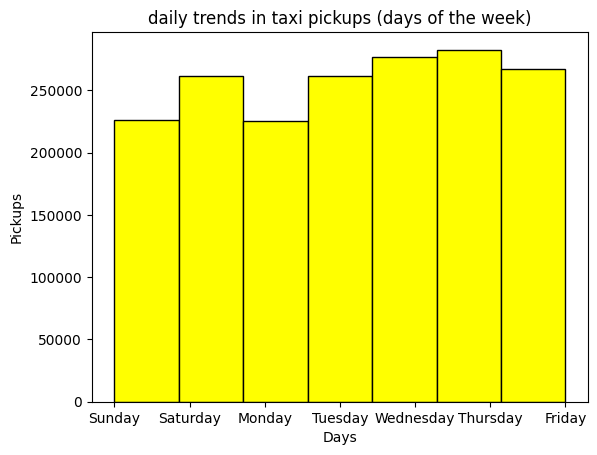

In [110]:
# Find and show the daily trends in taxi pickups (days of the week)
plt.hist(df.tpep_pickup_dayofweek, bins=7, edgecolor='black',color='yellow')
plt.title('daily trends in taxi pickups (days of the week)')
plt.xlabel('Days')
plt.ylabel('Pickups')
plt.show() 

# Conclusions from the Histogram:
# Overall all days have equivalant results
# Monday and Sunday are comparatively lower 

In [111]:
df['tpep_pickup_month'] = df.tpep_pickup_datetime.dt.month_name()

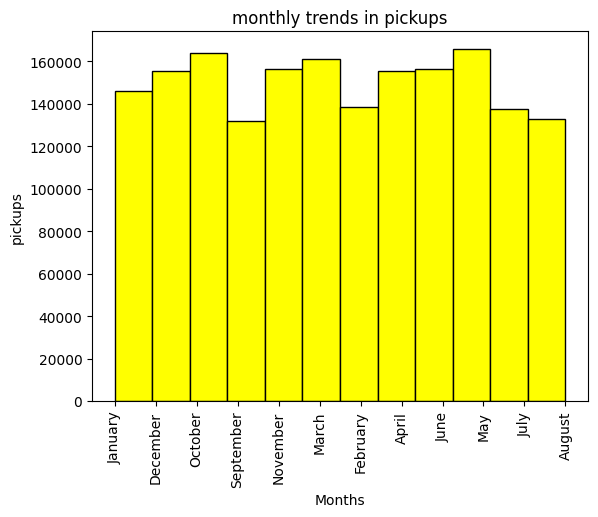

In [114]:
# Show the monthly trends in pickups
plt.hist(df.tpep_pickup_month, bins=12, edgecolor='black',color='yellow')
plt.title('monthly trends in pickups')
plt.xlabel('Months')
plt.ylabel('pickups')
plt.xticks(rotation=90)
plt.show() 

# Conclusions from the Histogram:
# Overall all Months have similar results, July August, September or Q3 is comparatively lower
# May and October Month are highest in pickups

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [115]:
# Analyse the above parameters

# Negative Columns
negative_columns = []
for column in df.select_dtypes(include=['float64', 'int64']):
    if (df[column] < 0).any():
        negative_columns.append(column)
        
negative_columns

# No Negative columns

[]

In [116]:
# Zero Columns
zero_columns = []
for column in df.select_dtypes(include=['float64', 'int64']):
    if (df[column] == 0).any():
        zero_columns.append(column)
        
zero_columns

['trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

In [118]:
# Zero Values should be removed from'trip_distance', 'fare_amount','total_amount'
df[df.trip_distance == 0]
df[df.fare_amount == 0]
df[df.total_amount == 0]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2288            1  2023-01-01 19:16:54   2023-01-01 19:17:15              1.0   
13042           1  2023-01-04 08:16:58   2023-01-04 08:17:17              1.0   
36518           1  2023-01-09 09:54:30   2023-01-09 09:58:55              1.0   
36586           1  2023-01-09 09:17:11   2023-01-09 09:17:18              6.0   
50443           2  2023-01-12 07:08:18   2023-01-12 07:08:45              1.0   
...           ...                  ...                   ...              ...   
1774661         1  2023-09-25 21:29:38   2023-09-25 21:32:52              2.0   
1776966         1  2023-09-26 13:16:50   2023-09-26 13:48:54              1.0   
1778665         1  2023-09-26 18:57:05   2023-09-26 19:07:08              1.0   
1786443         1  2023-09-28 07:00:00   2023-09-28 07:54:54              1.0   
1794584         1  2023-09-29 16:12:01   2023-09-29 16:13:12              1.0   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
2288               0.0         2.0           261           261             3   
13042              0.0         1.0           186           186             4   
36518              0.0         1.0           145           145             1   
36586              0.0         1.0           145           145             2   
50443              0.0         1.0           193           193             1   
...                ...         ...           ...           ...           ...   
1774661            0.0         1.0           140           140             3   
1776966            0.4        99.0            61            61             1   
1778665            2.7        99.0           205           218             1   
1786443            3.0        99.0            95           216             1   
1794584            0.0         1.0           237           237             3   

         fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
2288             0.0  ...         0.0           0.0                    0.0   
13042            0.0  ...         0.0           0.0                    0.0   
36518            0.0  ...         0.0           0.0                    0.0   
36586            0.0  ...         0.0           0.0                    0.0   
50443            0.0  ...         0.0           0.0                    0.0   
...              ...  ...         ...           ...                    ...   
1774661          0.0  ...         0.0           0.0                    0.0   
1776966          0.0  ...         0.0           0.0                    0.0   
1778665          0.0  ...         0.0           0.0                    0.0   
1786443          0.0  ...         0.0           0.0                    0.0   
1794584          0.0  ...         0.0           0.0                    0.0   

         total_amount  congestion_surcharge  airport_fee  tpep_pickup_date  \
2288              0.0                   0.0          0.0        2023-01-01   
13042             0.0                   0.0          0.0        2023-01-04   
36518             0.0                   0.0          0.0        2023-01-09   
36586             0.0                   0.0          0.0        2023-01-09   
50443             0.0                   0.0          0.0        2023-01-12   
...               ...                   ...          ...               ...   
1774661           0.0                   0.0          0.0        2023-09-25   
1776966           0.0                   0.0          0.0        2023-09-26   
1778665           0.0                   0.0          0.0        2023-09-26   
1786443           0.0                   0.0          0.0        2023-09-28   
1794584           0.0                   0.0          0.0        2023-09-29   

         tpep_pickup_hour tpep_pickup_dayofweek  tpep_pickup_month  
2288                   19                Sunday            January  
13042                   8             Wednesday            Janu

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [119]:
# Create a df with non zero entries for the selected parameters.
df = df[~(df.trip_distance == 0)]
df = df[~(df.fare_amount == 0)]
df = df[~(df.total_amount == 0)]
df.shape


(1779253, 22)

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [120]:
# Group data by month and analyse monthly revenue
df.groupby(['tpep_pickup_month'])['total_amount'].sum()


tpep_pickup_month
April        4402295.66
August       3824314.11
December     4471594.75
February     3720967.97
January      3934448.49
July         3930942.90
June         4514673.01
March        4482774.50
May          4795962.34
November     4496683.19
October      4822007.77
September    3905367.62
Name: total_amount, dtype: float64

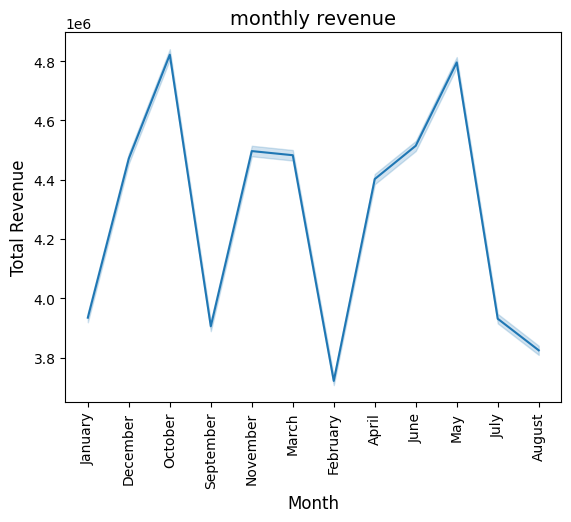

In [123]:
sns.lineplot(x=df.tpep_pickup_month, y=df.total_amount, estimator=np.sum)
plt.xticks(rotation=90)
plt.title('monthly revenue', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [124]:
df['tpep_pickup_quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q')

In [127]:
# Calculate proportion of each quarter
qtr_revenue = df.groupby('tpep_pickup_quarter')['total_amount'].sum().reset_index()
yearly_revenue = qtr_revenue['total_amount'].sum()
qtr_revenue['proportion'] = round((qtr_revenue['total_amount'] / yearly_revenue),2)
qtr_revenue.head()


tpep_pickup_quarter  total_amount  proportion
0              2022Q4         13.50        0.00
1              2023Q1   12138190.96        0.24
2              2023Q2   13712931.01        0.27
3              2023Q3   11660624.63        0.23
4              2023Q4   13790272.21        0.27

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

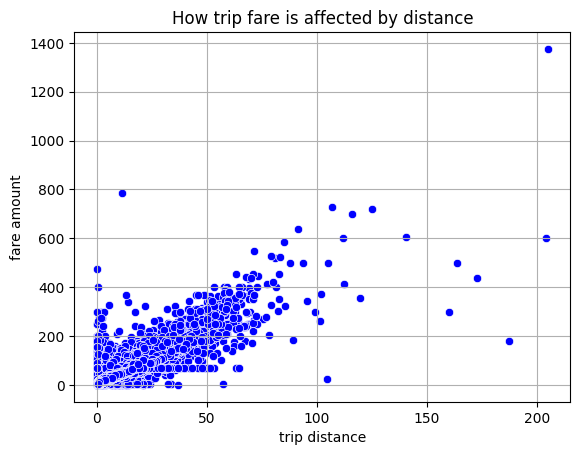

In [129]:
# Show how trip fare is affected by distance
sns.scatterplot(x=df.trip_distance,y=df.fare_amount, color='Blue')
plt.title('how trip fare is affected by distance')
plt.xlabel('trip distance')
plt.ylabel('fare amount')
plt.grid(True)
plt.show()

# Conclusions from the Scatter Plot:
# Longer the distance, higher trip fare

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [130]:
df['trip_duration_mins'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds().div(60).round(0).astype(int)

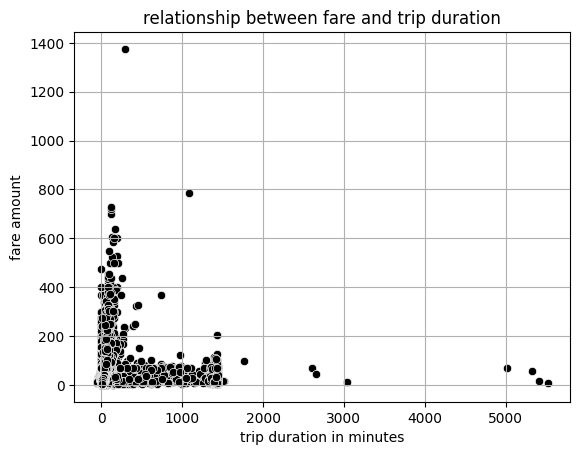

In [131]:
# Show relationship between fare and trip duration
sns.scatterplot(x=df.trip_duration_mins,y=df.fare_amount, color='Black')
plt.title('relationship between fare and trip duration')
plt.xlabel('trip duration in minutes')
plt.ylabel('fare amount')
plt.grid(True)
plt.show()

# Conclusions from the Scatter Plot:
# fare amount is higher for short trip duration

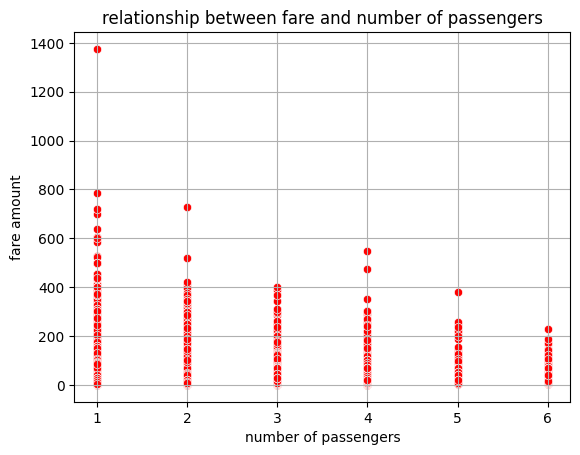

In [132]:
# Show relationship between fare and number of passengers

sns.scatterplot(x=df.passenger_count,y=df.fare_amount, color='red')
plt.title('relationship between fare and number of passengers')
plt.xlabel('number of passengers')
plt.ylabel('fare amount')
plt.grid(True)
plt.show()

# Conclusions from the Scatter Plot:
# fare amount is almost non variable with respect to number of passengers

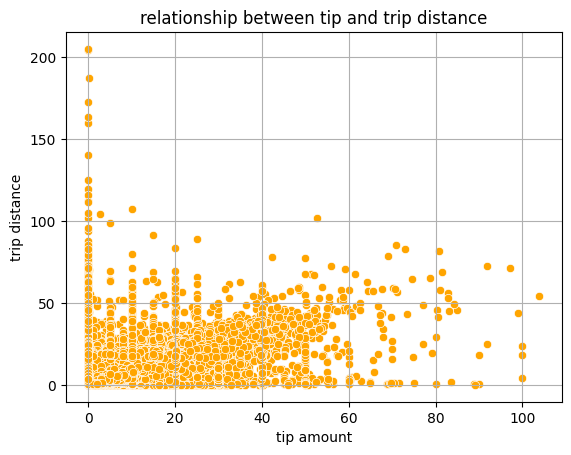

In [133]:
# Show relationship between tip and trip distance

sns.scatterplot(x=df.tip_amount,y=df.trip_distance, color='Orange')
plt.title('relationship between tip and trip distance')
plt.xlabel('tip amount')
plt.ylabel('trip distance')
plt.grid(True)
plt.show()

# Conclusions from the Scatter Plot:
# tip amount is 0 when the tip distance is lower
# Maximum tip amounts lie between 0 to 50 miles distance

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [136]:
df.payment_type.value_counts()

payment_type
1    1456383
2     304573
4      12092
3       6205
Name: count, dtype: int64

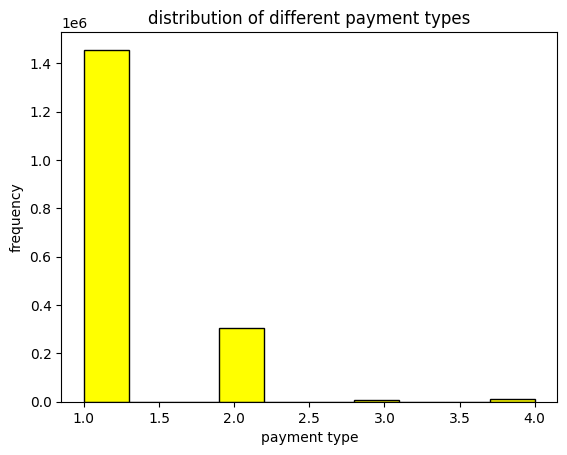

In [139]:
# Analyse the distribution of different payment types (payment_type).

plt.hist(df.payment_type,edgecolor='black',color='yellow')
plt.title('distribution of different payment types')
plt.xlabel('payment type')
plt.ylabel('frequency')
plt.show() 
# Conclusions from the histogram:
# 1= Credit card has the highest frequency
# 2= Cash is the 2nd highest frequency

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [140]:
!pip install geopandas

   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   ----- ---------------------------------- 2.6/19.2 MB 13.7 MB/s eta 0:00:02
   ------------ --------------------------- 6.0/19.2 MB 15.4 MB/s eta 0:00:01
   -------------------- ------------------- 10.0/19.2 MB 16.8 MB/s eta 0:00:01
   ---------------------------- ----------- 13.6/19.2 MB 17.1 MB/s eta 0:00:01
   ------------------------------------- -- 18.1/19.2 MB 17.8 MB/s eta 0:00:01
   ---------------------------------------- 19.2/19.2 MB 17.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   -------------------------- ------------- 4.2/6.3 MB 21.0 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 20.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 18.5 MB/s eta 0:00:00


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [158]:
# Read the shapefile using geopandas
import geopandas as gpd
zones = gpd.read_file(r'C:\\Users\\Sagar\\AIML Module Learning\EDA - Assignment (NYC Taxi)\\Starter Notebook - EDA NYC Taxi\taxi_zones\taxi_zones.shp') 
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [160]:
print(zones.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

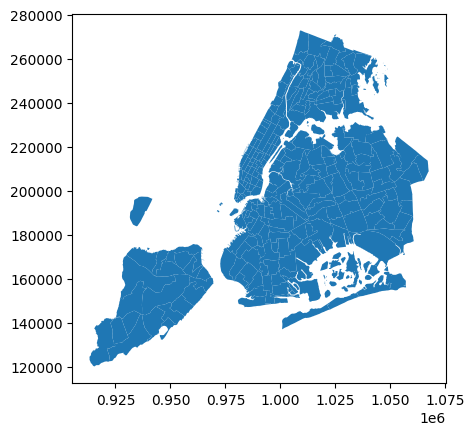

In [161]:
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [213]:
# Merge zones and trip records using locationID and PULocationID
merged_df=pd.merge(df,zones,how='inner',left_on='PULocationID',right_on='LocationID')
merged_df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         1  2023-01-01 00:42:56   2023-01-01 01:16:33              2.0   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0           7.74         1.0           138           256             2   
1           1.24         1.0           161           237             1   
2           1.44         1.0           237           141             2   
3           0.54         1.0           143           142             2   
4           7.10         1.0           246            37             1   

   fare_amount  ...  trip_duration_mins  avg_trip_duration_per_hour  \
0         32.4  ...                  16                   15.699138   
1          7.9  ...                   5                   15.699138   
2         11.4  ...                  11                   15.699138   
3          6.5  ...                   5                   15.699138   
4         34.5  ...                  34                   15.699138   

   route_speed  OBJECTID  Shape_Leng  Shape_Area                       zone  \
0      0.49302       138    0.107467    0.000537          LaGuardia Airport   
1      0.07899       161    0.035804    0.000072             Midtown Center   
2      0.09172       237    0.042213    0.000096      Upper East Side South   
3      0.03440       143    0.054180    0.000151        Lincoln Square West   
4      0.45225       246    0.069467    0.000281  West Chelsea/Hudson Yards   

   LocationID    borough                                           geometry  
0         138     Queens  MULTIPOLYGON (((1019904.219 225677.983, 102031...  
1         161  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...  
2         237  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...  
3         143  Manhattan  POLYGON ((989338.1 223572.253, 989368.225 2235...  
4         246  Manhattan  POLYGON ((983031.177 217138.506, 983640.32 216...  

[5 rows x 33 columns]

In [214]:
merged_df.shape

(1763327, 33)

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [215]:
# Group data by location and calculate the number of trips
merged_df.LocationID.unique().size

aggregated_data = merged_df.groupby(['LocationID']).agg(
    trips=('LocationID', 'count')
)

print(aggregated_data)

            trips
LocationID       
1              47
2               2
3              31
4            1775
5               9
...           ...
259            35
260           299
261          9370
262         23125
263         34096

[251 rows x 1 columns]


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [216]:
# Merge trip counts back to the zones GeoDataFrame
merged_df1 = pd.merge(zones,aggregated_data,how='left',on='LocationID')
merged_df1.head()



OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry   trips  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...    47.0  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...     2.0  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...    31.0  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  1775.0  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...     9.0

In [217]:
merged_df1.shape

(263, 8)

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

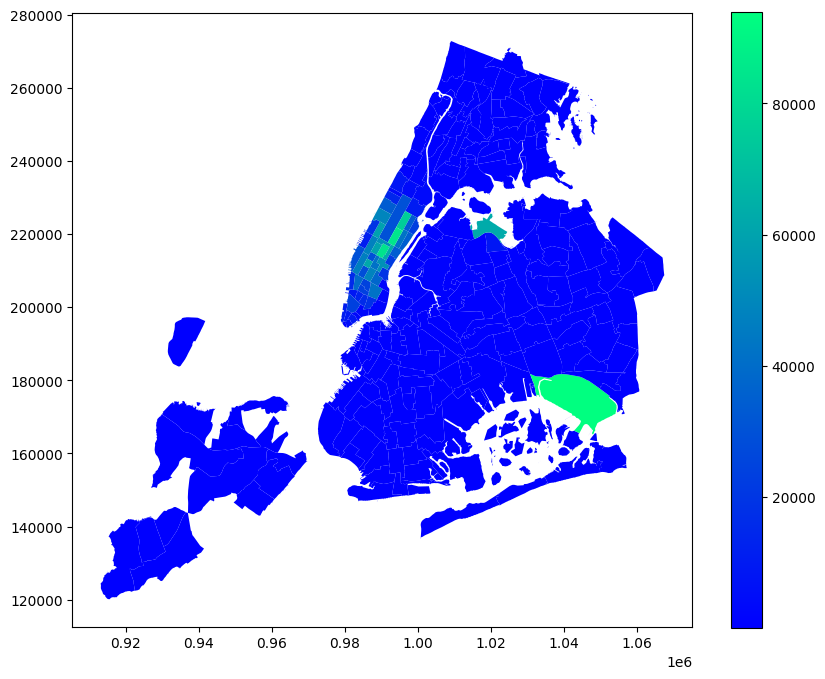

In [218]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

# Plot the map and display it
merged_df1.plot(ax = ax,legend = True,column='trips',cmap='winter')
plt.show()

In [219]:
# can you try displaying the zones DF sorted by the number of trips?
merged_df1_sorted = merged_df1.sort_values(by='trips',ascending=False)
merged_df1_sorted.head()

OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
131       132    0.245479    0.002038            JFK Airport         132   
236       237    0.042213    0.000096  Upper East Side South         237   
160       161    0.035804    0.000072         Midtown Center         161   
235       236    0.044252    0.000103  Upper East Side North         236   
161       162    0.035270    0.000048           Midtown East         162   

       borough                                           geometry    trips  
131     Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...  93936.0  
236  Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...  85002.0  
160  Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...  83988.0  
235  Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...  75706.0  
161  Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...  64175.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


Findings
The busiest hours for taxi pickups are late afternoon/early evening (5 PM - 7 PM).
Pickups are relatively consistent throughout the week, with slight dips on Mondays and Sundays.
May and October are the months with the highest pickup activity.
Monthly revenue generally follows the pattern of pickups.
There is a positive correlation between trip distance and fare amount.
Fare amount is largely independent of passenger count.
Tip amounts tend to be higher for longer distances but are influenced by other factors.
Credit card is the most frequent payment method.
The geographical map of pickups clearly identifies zones with high demand.

#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [220]:
# Find routes which have the slowest speeds at different times of the day

df['avg_trip_duration_per_hour']=df.groupby('tpep_pickup_hour')['trip_duration_mins'].transform('mean')
df['route_speed'] = round((df['trip_distance']/df['avg_trip_duration_per_hour']),5)
df_sorted = df.sort_values(by='route_speed')
df_sorted.head(10)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1402767         2  2023-05-10 16:42:21   2023-05-10 16:42:39              1.0   
551388          2  2023-12-15 16:43:59   2023-12-15 16:44:47              1.0   
1615236         2  2023-07-20 16:59:04   2023-07-20 16:59:18              1.0   
1313045         2  2023-04-25 16:58:45   2023-04-25 17:00:07              1.0   
1335873         2  2023-04-22 16:26:57   2023-04-22 16:27:11              1.0   
1633815         2  2023-07-24 16:53:20   2023-07-24 16:53:34              2.0   
738383          2  2023-03-26 16:22:42   2023-03-26 16:23:07              1.0   
1280663         2  2023-04-13 16:02:57   2023-04-13 16:03:27              1.0   
497735          2  2023-12-06 16:27:25   2023-12-06 16:27:41              2.0   
1430671         2  2023-05-15 16:23:09   2023-05-15 16:23:23              1.0   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
1402767           0.01         2.0           132           132             2   
551388            0.01         1.0           162           161             4   
1615236           0.01         2.0           164           164             1   
1313045           0.01         1.0           164           186             4   
1335873           0.01         1.0            48           230             2   
1633815           0.01         2.0           209            87             1   
738383            0.01         1.0           138           138             2   
1280663           0.01         1.0           231           231             2   
497735            0.01         5.0           132           132             1   
1430671           0.01         2.0           162           161             1   

         fare_amount  ...  congestion_surcharge  airport_fee  \
1402767         70.0  ...                   0.0          3.5   
551388           3.0  ...                   2.5          0.0   
1615236         70.0  ...                   2.5          0.0   
1313045          3.7  ...                   2.5          0.0   
1335873          3.0  ...                   2.5          0.0   
1633815         70.0  ...                   2.5          0.0   
738383           3.0  ...                   0.0          0.0   
1280663          3.0  ...                   2.5          0.0   
497735          87.0  ...                   0.0          3.5   
1430671         70.0  ...                   2.5          0.0   

         tpep_pickup_date  tpep_pickup_hour  tpep_pickup_dayofweek  \
1402767        2023-05-10                16              Wednesday   
551388         2023-12-15                16                 Friday   
1615236        2023-07-20                16               Thursday   
1313045        2023-04-25                16                Tuesday   
1335873        2023-04-22                16               Saturday   
1633815        2023-07-24                16                 Monday   
738383         2023-03-26                16                 Sunday   
1280663        2023-04-13                16               Thursday   
497735         2023-12-06                16              Wednesday   
1430671        2023-05-15                16                 Monday   

         tpep_pickup_month  tpep_pickup_quarter  trip_duration_mins  \
1402767                May               2023Q2                   0   
551388            December               2023Q4                   1   
1615236               July               2023Q3                   0   
1313045              April               2023Q2                   1   
1335873              April               2023Q2                   0   
1633815               July               2023Q3                   0   
738383               March               2023Q1                   0   
1280663              April               2023Q2                   0   
497735            December               2023Q4                   0   
1430671                May               2023Q2   

In [202]:
route_speed_hour = df.groupby(['tpep_pickup_hour']).agg(route_speed=('route_speed', 'mean'))

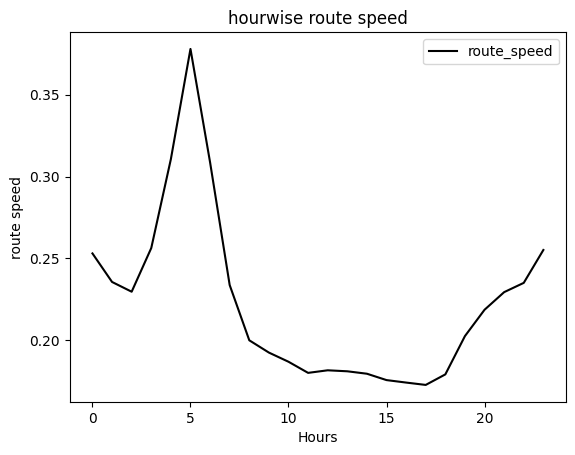

In [221]:
route_speed_hour.plot.line(color ='black')
plt.title('hourwise route speed')
plt.xlabel('Hours')
plt.ylabel('route speed')
plt.show()

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

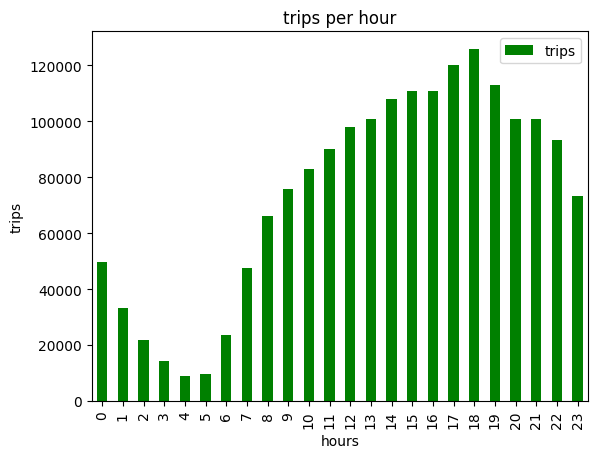

In [222]:
# Visualise the number of trips per hour and find the busiest hour
per_hour_trips = df.groupby(['tpep_pickup_hour']).agg(trips=('tpep_pickup_hour', 'count'))

per_hour_trips.plot.bar(color = 'green')
plt.title('trips per hour')
plt.xlabel('hours')
plt.ylabel('trips')
plt.show()

# Conclusions from the bar graph:
# early mornings (4 - 6 am) has least amount of trips
# Number of trips increases after 6 AM gradually and reaches to peak at 18 hrs
# busiest hour is '18'

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

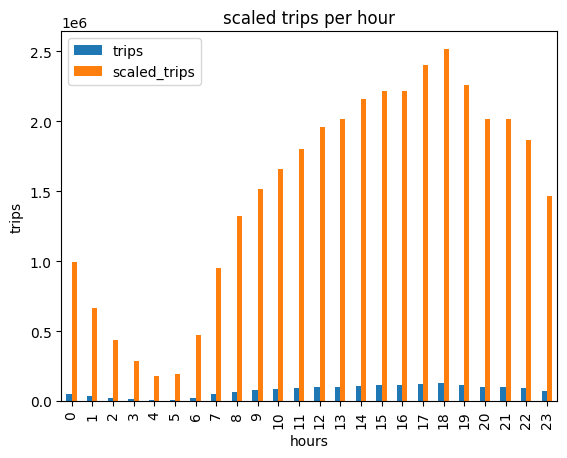

In [223]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.05
per_hour_trips['scaled_trips'] = per_hour_trips.trips/sample_fraction

per_hour_trips.plot.bar()
plt.title('scaled trips per hour')
plt.xlabel('hours')
plt.ylabel('trips')
plt.show()

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

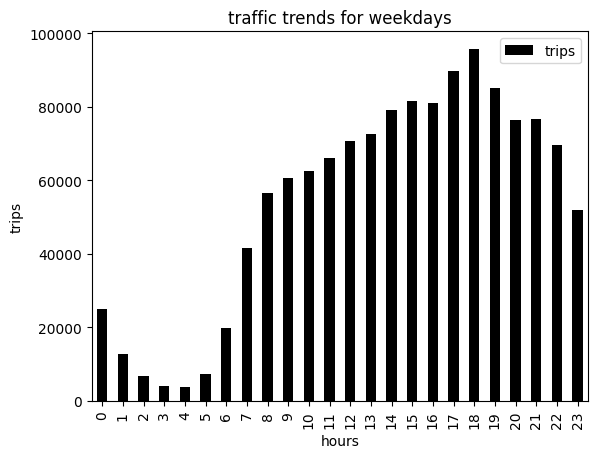

In [224]:
# Compare traffic trends for the week days and weekends

#Traffic Trends for weekdays:
df[~(df.tpep_pickup_dayofweek.isin(['Sunday','Saturday']))].groupby(['tpep_pickup_hour']).agg(trips=('tpep_pickup_hour', 'count')).plot.bar(color ='black')

plt.title('traffic trends for weekdays')
plt.xlabel('hours')
plt.ylabel('trips')
plt.show()


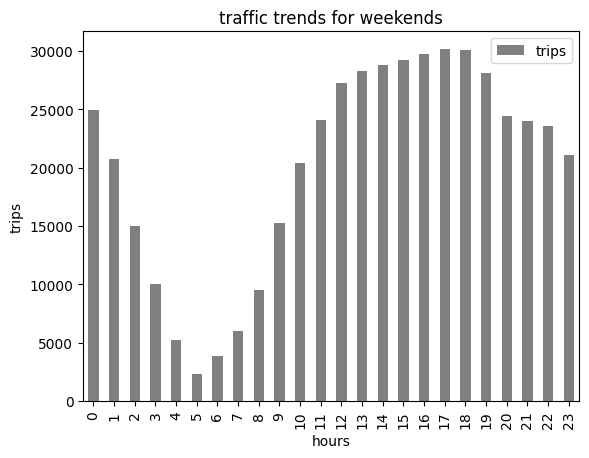

In [225]:
#Traffic Trends for weekend:
df[(df.tpep_pickup_dayofweek.isin(['Sunday','Saturday']))].groupby(['tpep_pickup_hour']).agg(trips=('tpep_pickup_hour', 'count')).plot.bar(color ='grey')

plt.title('traffic trends for weekends')
plt.xlabel('hours')
plt.ylabel('trips')
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

In [ ]:
# Conclusions from the weekday vs weekend graph:
# Traffic trends for weekdays and weekends have similar pattern, 
# Generally less trips in the mornings 4 AN to 8 AM, then it gradually increases throughout the day and decreases after 18 PM

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [226]:
# Find top 10 pickup and dropoff zones
zone_hour_pickup = merged_df.groupby(['zone','tpep_pickup_hour']).agg(
    trips=('zone', 'count')
)

zone_hour_pickup_sorted = zone_hour_pickup.sort_values(by='trips',ascending=False)
zone_hour_pickup_sorted.reset_index(inplace=True)
zone_hour_pickup_sorted.head(10)


zone  tpep_pickup_hour  trips
0         Midtown Center                18   7297
1         Midtown Center                17   7020
2            JFK Airport                22   6555
3            JFK Airport                16   6545
4            JFK Airport                15   6512
5         Midtown Center                16   6506
6  Upper East Side South                18   6451
7  Upper East Side South                17   6445
8  Upper East Side South                14   6437
9  Upper East Side South                15   6405

In [227]:
# Add Drop off hour
merged_df["tpep_dropoff_hour"] = pd.to_datetime(merged_df["tpep_dropoff_datetime"]).dt.hour

In [228]:
# Need to create a new merged DF joining drop location if
merged_df2 = pd.merge(merged_df,zones,how='inner',left_on='DOLocationID',right_on='LocationID')
merged_df2.shape

(1753215, 41)

In [229]:
zone_hour_drop = merged_df2.groupby(['zone_y','tpep_dropoff_hour']).agg(
    trips=('zone_y', 'count')
)

zone_hour_drop_sorted = zone_hour_drop.sort_values(by='trips',ascending=False)
zone_hour_drop_sorted.reset_index(inplace=True)
zone_hour_drop_sorted.head(10)

zone_y  tpep_dropoff_hour  trips
0  Upper East Side South                 18   6143
1  Upper East Side North                 15   6137
2  Upper East Side North                 18   5969
3  Upper East Side South                 12   5967
4  Upper East Side South                 15   5762
5  Upper East Side North                 14   5705
6  Upper East Side North                 17   5654
7  Upper East Side North                 16   5621
8  Upper East Side South                 14   5517
9  Upper East Side South                 17   5404

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [231]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
total_trips = merged_df2.shape[0]
zone_drop = merged_df2.groupby(['zone_y']).agg(trips_d=('zone_y', 'count'))
zone_drop['ratio_d']=round((zone_drop.trips_d/total_trips),4)
zone_drop.reset_index(inplace=True)
zone_drop.head(10)


zone_y  trips_d  ratio_d
0  Allerton/Pelham Gardens      146   0.0001
1            Alphabet City     6685   0.0038
2            Arden Heights       30   0.0000
3  Arrochar/Fort Wadsworth       60   0.0000
4                  Astoria     5026   0.0029
5             Astoria Park       38   0.0000
6               Auburndale      189   0.0001
7             Baisley Park     1732   0.0010
8               Bath Beach      129   0.0001
9             Battery Park     1003   0.0006

In [232]:
zone_pick = merged_df2.groupby(['zone_x']).agg(
    trips_p=('zone_x', 'count')
)
zone_pick['ratio_p']=round((zone_pick.trips_p/total_trips),6)
zone_pick.reset_index(inplace=True)
zone_pick.head(10)

zone_x  trips_p   ratio_p
0  Allerton/Pelham Gardens       31  0.000018
1            Alphabet City     1769  0.001009
2            Arden Heights        9  0.000005
3  Arrochar/Fort Wadsworth       21  0.000012
4                  Astoria      726  0.000414
5             Astoria Park        4  0.000002
6               Auburndale       23  0.000013
7             Baisley Park      499  0.000285
8               Bath Beach       23  0.000013
9             Battery Park      796  0.000454

In [233]:
# Merge the zone data for pick up and drop
merged_zone_pick_drop = pd.merge(zone_pick,zone_drop,how='outer',left_on='zone_x',right_on='zone_y')
merged_zone_pick_drop.head()

zone_x  trips_p   ratio_p                   zone_y  \
0  Allerton/Pelham Gardens     31.0  0.000018  Allerton/Pelham Gardens   
1            Alphabet City   1769.0  0.001009            Alphabet City   
2            Arden Heights      9.0  0.000005            Arden Heights   
3  Arrochar/Fort Wadsworth     21.0  0.000012  Arrochar/Fort Wadsworth   
4                  Astoria    726.0  0.000414                  Astoria   

   trips_d  ratio_d  
0    146.0   0.0001  
1   6685.0   0.0038  
2     30.0   0.0000  
3     60.0   0.0000  
4   5026.0   0.0029

In [ ]:
# Display the 10 highest pickup

In [234]:
merged_zone_pick_drop = merged_zone_pick_drop.sort_values(by='ratio_p',ascending=False)
merged_zone_pick_drop.head(10)

zone_x  trips_p   ratio_p  \
121                   JFK Airport  90363.0  0.051541   
231         Upper East Side South  84799.0  0.048368   
154                Midtown Center  83729.0  0.047757   
230         Upper East Side North  75507.0  0.043068   
155                  Midtown East  63968.0  0.036486   
131             LaGuardia Airport  61969.0  0.035346   
180  Penn Station/Madison Sq West  61602.0  0.035137   
224     Times Sq/Theatre District  59510.0  0.033943   
135           Lincoln Square East  59301.0  0.033824   
163                   Murray Hill  53028.0  0.030246   

                           zone_y  trips_d  ratio_d  
121                   JFK Airport  19021.0   0.0108  
231         Upper East Side South  75685.0   0.0432  
154                Midtown Center  69815.0   0.0398  
230         Upper East Side North  79416.0   0.0453  
155                  Midtown East  50869.0   0.0290  
131             LaGuardia Airport  21399.0   0.0122  
180  Penn Station/Madison Sq West  39026.0   0.0223  
224     Times Sq/Theatre District  54846.0   0.0313  
135           Lincoln Square East  50222.0   0.0286  
163                   Murray Hill  53007.0   0.0302

In [235]:
# Display the 10 highest drop
merged_zone_pick_drop = merged_zone_pick_drop.sort_values(by='ratio_d',ascending=False)
merged_zone_pick_drop.head(10)

zone_x  trips_p   ratio_p                     zone_y  \
230      Upper East Side North  75507.0  0.043068      Upper East Side North   
231      Upper East Side South  84799.0  0.048368      Upper East Side South   
154             Midtown Center  83729.0  0.047757             Midtown Center   
224  Times Sq/Theatre District  59510.0  0.033943  Times Sq/Theatre District   
163                Murray Hill  53028.0  0.030246                Murray Hill   
155               Midtown East  63968.0  0.036486               Midtown East   
233      Upper West Side South  48957.0  0.027924      Upper West Side South   
135        Lincoln Square East  59301.0  0.033824        Lincoln Square East   
134            Lenox Hill West  42332.0  0.024145            Lenox Hill West   
64                East Chelsea  46457.0  0.026498               East Chelsea   

     trips_d  ratio_d  
230  79416.0   0.0453  
231  75685.0   0.0432  
154  69815.0   0.0398  
224  54846.0   0.0313  
163  53007.0   0.0302  
155  50869.0   0.0290  
233  50070.0   0.0286  
135  50222.0   0.0286  
134  47350.0   0.0270  
64   45125.0   0.0257

In [236]:
# Display the 10 lowest pickup
merged_zone_pick_drop = merged_zone_pick_drop.sort_values(by='trips_p',ascending=True)
merged_zone_pick_drop.head(10)

zone_x  trips_p   ratio_p  \
178                      Pelham Bay Park      1.0  0.000001   
165               New Dorp/Midland Beach      1.0  0.000001   
103                  Green-Wood Cemetery      1.0  0.000001   
24   Breezy Point/Fort Tilden/Riis Beach      1.0  0.000001   
107                  Grymes Hill/Clifton      1.0  0.000001   
80     Eltingville/Annadale/Prince's Bay      1.0  0.000001   
200            Saint George/New Brighton      2.0  0.000001   
110          Heartland Village/Todt Hill      2.0  0.000001   
124                          Jamaica Bay      2.0  0.000001   
193                        Rikers Island      2.0  0.000001   

                                  zone_y  trips_d  ratio_d  
178                      Pelham Bay Park     21.0      0.0  
165               New Dorp/Midland Beach     12.0      0.0  
103                  Green-Wood Cemetery     17.0      0.0  
24   Breezy Point/Fort Tilden/Riis Beach     36.0      0.0  
107                  Grymes Hill/Clifton     22.0      0.0  
80     Eltingville/Annadale/Prince's Bay      8.0      0.0  
200            Saint George/New Brighton     28.0      0.0  
110          Heartland Village/Todt Hill     40.0      0.0  
124                          Jamaica Bay      3.0      0.0  
193                                  NaN      NaN      NaN

In [237]:
# Display the 10 lowest drop
merged_zone_pick_drop = merged_zone_pick_drop.sort_values(by='trips_d',ascending=True)
merged_zone_pick_drop.head(10)

zone_x  trips_p   ratio_p  \
95                                 NaN      NaN       NaN   
124                        Jamaica Bay      2.0  0.000001   
198                  Rossville/Woodrow      4.0  0.000002   
181                                NaN      NaN       NaN   
80   Eltingville/Annadale/Prince's Bay      1.0  0.000001   
165             New Dorp/Midland Beach      1.0  0.000001   
170                                NaN      NaN       NaN   
55                        Crotona Park      2.0  0.000001   
103                Green-Wood Cemetery      1.0  0.000001   
27                                 NaN      NaN       NaN   

                                zone_y  trips_d  ratio_d  
95                     Freshkills Park      3.0      0.0  
124                        Jamaica Bay      3.0      0.0  
198                  Rossville/Woodrow      6.0      0.0  
181                      Port Richmond      7.0      0.0  
80   Eltingville/Annadale/Prince's Bay      8.0      0.0  
165             New Dorp/Midland Beach     12.0      0.0  
170                            Oakwood     12.0      0.0  
55                        Crotona Park     13.0      0.0  
103                Green-Wood Cemetery     17.0      0.0  
27                       Broad Channel     18.0      0.0

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [238]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

#Pick Up
zone_hour_pickup_sorted.reset_index(inplace=True)
zone_hour_pickup_sorted[zone_hour_pickup_sorted.tpep_pickup_hour.isin([23,0,1,2,3,4])].head(10)

index                       zone  tpep_pickup_hour  trips
17      17                JFK Airport                23   6033
78      78                JFK Airport                 0   3841
80      80          LaGuardia Airport                23   3806
107    107               East Village                23   3518
110    110               East Village                 0   3493
123    123               West Village                23   3383
143    143               East Village                 1   3206
156    156  Times Sq/Theatre District                23   3077
164    164               West Village                 0   3033
166    166               Clinton East                23   2996

In [239]:
## Drop Off
zone_hour_drop_sorted.reset_index(inplace=True)
zone_hour_drop_sorted[zone_hour_drop_sorted.tpep_dropoff_hour.isin([23,0,1,2,3,4])].head(10)

index                 zone_y  tpep_dropoff_hour  trips
157    157           East Village                 23   2631
224    224           Clinton East                 23   2237
226    226        Lenox Hill West                 23   2227
230    230  Upper East Side North                 23   2201
236    236           East Village                  0   2175
237    237            Murray Hill                 23   2170
266    266               Gramercy                 23   2024
278    278  Upper West Side South                 23   1977
289    289           East Chelsea                 23   1930
297    297         Yorkville West                 23   1906

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [241]:
# Filter for night hours (11 PM to 5 AM)
df_nighttime = df[df.tpep_pickup_hour.isin([23,0,1,2,3,4])]
df_daytime = df[~(df.tpep_pickup_hour.isin([23,0,1,2,3,4]))]

total_revenue = round(df['total_amount'].sum(),2)
nighttime_revenue = round(df_nighttime['total_amount'].sum(),2)
daytime_revenue = round(df_daytime['total_amount'].sum(),2)

# print(f"NightTime Revenue = {nighttime_revenue} \nDayTime Revenue = {daytime_revenue} \nTotal Revenue = {total_revenue}" )
night_revenue_share = round(100* nighttime_revenue / total_revenue,2)
datyime_revenue_share = round(100* daytime_revenue / total_revenue,2)

print(f"NightTime Revenue Share is {night_revenue_share} %" )
print(f"DayTime Revenue Share is {datyime_revenue_share} %" )


NightTime Revenue Share is 11.32 %
DayTime Revenue Share is 88.68 %


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

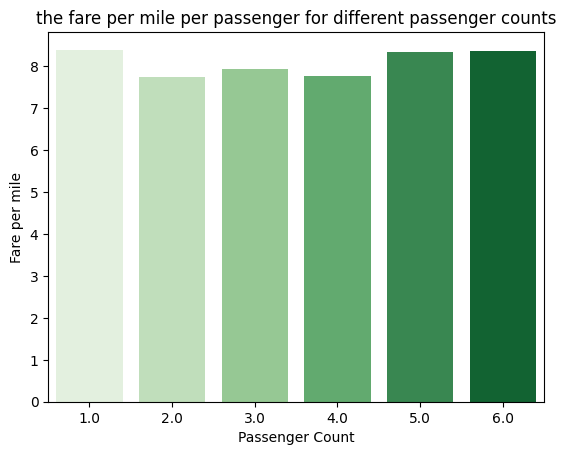

In [243]:
# Analyse the fare per mile per passenger for different passenger counts
passenger_fare = df.groupby(['passenger_count']).agg(avg_amount=('total_amount', 'mean'),avg_distance=('trip_distance', 'mean'))
passenger_fare['fare_per_mile']=round((passenger_fare.avg_amount)/(passenger_fare.avg_distance),2)

sns.barplot(data=passenger_fare, x='passenger_count', y='fare_per_mile', palette='Greens')
plt.title('the fare per mile per passenger for different passenger counts')
plt.xlabel('Passenger Count')
plt.ylabel('Fare per mile')
plt.show()

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

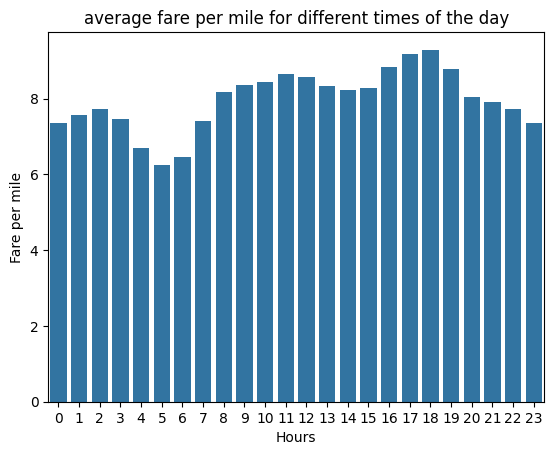

In [249]:
# Compare the average fare per mile for different days and for different times of the day
hourly_fare = df.groupby(['tpep_pickup_hour']).agg(avg_amount=('total_amount', 'mean'),avg_distance=('trip_distance', 'mean'))
hourly_fare['fare_per_mile']=round((hourly_fare.avg_amount)/(hourly_fare.avg_distance),2)

sns.barplot(data=hourly_fare, x='tpep_pickup_hour', y='fare_per_mile')
plt.title('average fare per mile for different times of the day')
plt.xlabel('Hours')
plt.ylabel('Fare per mile')
plt.show()


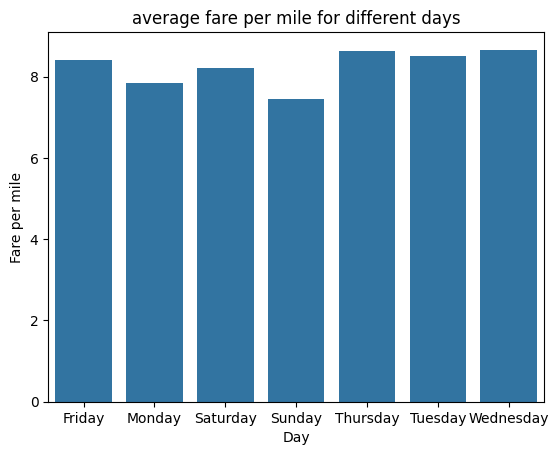

In [251]:
daily_fare = df.groupby(['tpep_pickup_dayofweek']).agg(avg_amount=('total_amount', 'mean'),avg_distance=('trip_distance', 'mean'))

daily_fare['fare_per_mile']=round((daily_fare.avg_amount)/(daily_fare.avg_distance),2)

sns.barplot(data=daily_fare, x='tpep_pickup_dayofweek', y='fare_per_mile')
plt.title('average fare per mile for different days')
plt.xlabel('Day')
plt.ylabel('Fare per mile')
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [252]:
# Compare fare per mile for different vendors
vendor_hourly_fare = df.groupby(['VendorID','tpep_pickup_hour']).agg(avg_amount=('total_amount', 'mean'),avg_distance=('trip_distance', 'mean'))

vendor_hourly_fare['fare_per_mile']=round((vendor_hourly_fare.avg_amount)/(vendor_hourly_fare.avg_distance),2)
vendor_hourly_fare.reset_index(inplace=True)
vendor_hourly_fare.head(48)


VendorID  tpep_pickup_hour  avg_amount  avg_distance  fare_per_mile
0          1                 0   27.564657      3.688165           7.47
1          1                 1   26.025888      3.450770           7.54
2          1                 2   24.297954      3.126671           7.77
3          1                 3   25.715799      3.485559           7.38
4          1                 4   31.782485      4.933923           6.44
5          1                 5   36.281087      6.037422           6.01
6          1                 6   29.724802      4.693419           6.33
7          1                 7   25.745358      3.485136           7.39
8          1                 8   25.325273      3.128178           8.10
9          1                 9   25.622922      3.087524           8.30
10         1                10   25.797809      3.086143           8.36
11         1                11   26.023563      3.066137           8.49
12         1                12   26.240072      3.083924           8.51
13         1                13   27.199534      3.276881           8.30
14         1                14   28.029241      3.387325           8.27
15         1                15   27.957354      3.340444           8.37
16         1                16   29.745274      3.329811           8.93
17         1                17   28.505434      3.060259           9.31
18         1                18   26.871732      2.854992           9.41
19         1                19   27.236413      3.086215           8.83
20         1                20   26.869564      3.296609           8.15
21         1                21   27.312783      3.427438           7.97
22         1                22   28.146959      3.633083           7.75
23         1                23   29.301402      3.959072           7.40
24         2                 0   29.658141      4.052407           7.32
25         2                 1   26.791658      3.532195           7.58
26         2                 2   25.398857      3.294500           7.71
27         2                 3   26.534486      3.550371           7.47
28         2                 4   33.677590      4.970675           6.78
29         2                 5   39.438249      6.201715           6.36
30         2                 6   32.847983      5.055933           6.50
31         2                 7   28.112450      3.793303           7.41
32         2                 8   27.037215      3.299072           8.20
33         2                 9   27.487765      3.275032           8.39
34         2                10   27.541134      3.251689           8.47
35         2                11   27.846555      3.204181           8.69
36         2                12   28.467233      3.315266           8.59
37         2                13   29.360122      3.521632           8.34
38         2                14   30.680767      3.732111           8.22
39         2                15   30.507810      3.690602           8.27
40         2                16   32.574244      3.700297           8.80
41         2                17   30.607043      3.345420           9.15
42         2                18   28.943674      3.129026           9.25
43         2                19   28.857309      3.291510           8.77
44         2                20   28.703264      3.586990           8.00
45         2                21   28.716808      3.639512           7.89
46         2                22   29.517306      3.827703           7.71
47         2                23   31.031339      4.224060           7.35

Text(0.5, 1.0, 'Vendor 2')

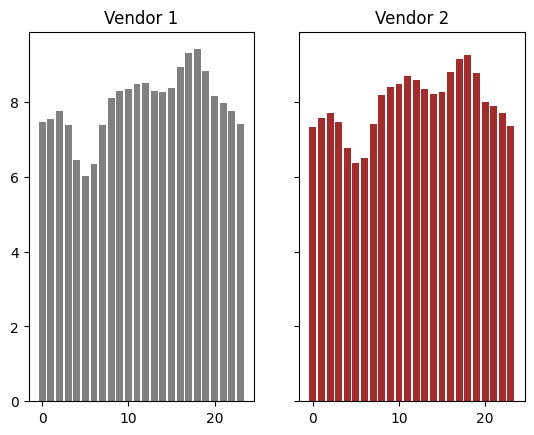

In [257]:
vendor_hourly_fare_v1 = vendor_hourly_fare[vendor_hourly_fare.VendorID == 1]
vendor_hourly_fare_v2 = vendor_hourly_fare[vendor_hourly_fare.VendorID == 2]
fig,ax = plt.subplots(ncols=2,sharey=True)
vendor1=ax[0].bar(vendor_hourly_fare_v1.tpep_pickup_hour, vendor_hourly_fare_v1.fare_per_mile,color='grey')
vendor2=ax[1].bar(vendor_hourly_fare_v2.tpep_pickup_hour, vendor_hourly_fare_v2.fare_per_mile,color='brown')
ax[0].set_title('Vendor 1')
ax[1].set_title('Vendor 2')

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [258]:
# Defining distance tiers
df['Tier']=df.trip_distance.apply(lambda x: "Tier1" if(x < 2) else ( "Tier2" if (x < 5)  else "Tier3"))

vendor_tier_fare = df.groupby(['VendorID','Tier']).agg(
    avg_amount=('total_amount', 'mean'),
    avg_distance=('trip_distance', 'mean')
)

vendor_tier_fare['fare_per_mile']=round((vendor_tier_fare.avg_amount)/(vendor_tier_fare.avg_distance),2)
vendor_tier_fare.reset_index(inplace=True)
vendor_tier_fare.head(10)


VendorID   Tier  avg_amount  avg_distance  fare_per_mile
0         1  Tier1   16.676603      1.119566          14.90
1         1  Tier2   26.658508      2.940562           9.07
2         1  Tier3   64.774547     11.386493           5.69
3         2  Tier1   17.277564      1.155879          14.95
4         2  Tier2   27.608858      2.988527           9.24
5         2  Tier3   68.933303     11.816584           5.83

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

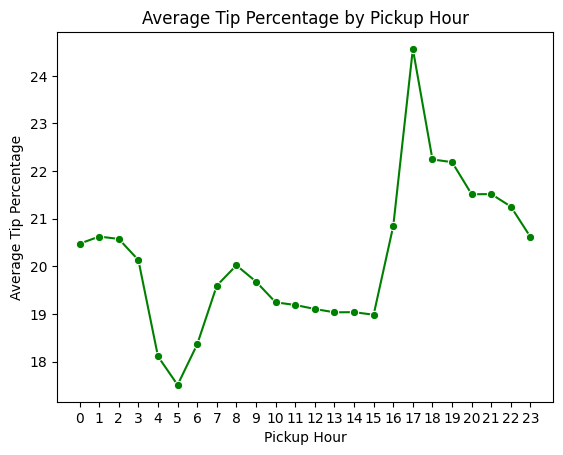

In [262]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# Average Tip Percentage by Pickup Times
df['tip_percentage']=round(100*(df.tip_amount/df.fare_amount),2)
avg_tip_hour = df.groupby('tpep_pickup_hour')['tip_percentage'].mean().reset_index()
sns.lineplot(data=avg_tip_hour, x='tpep_pickup_hour', y='tip_percentage', marker='o', color='green')
plt.title('Average Tip Percentage by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Tip Percentage')
plt.xticks(range(0, 24))
plt.show()


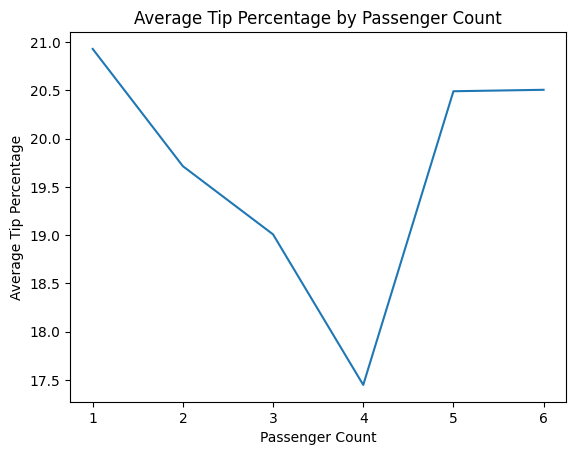

In [263]:
# Average Tip Percentage by Passenger Count

avg_tip_passenger_count = df.groupby(['passenger_count']).agg(
    tip_percentage=('tip_percentage', 'mean')
)
sns.lineplot(data=avg_tip_passenger_count, x='passenger_count', y='tip_percentage')
plt.title('Average Tip Percentage by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Percentage')
plt.show()



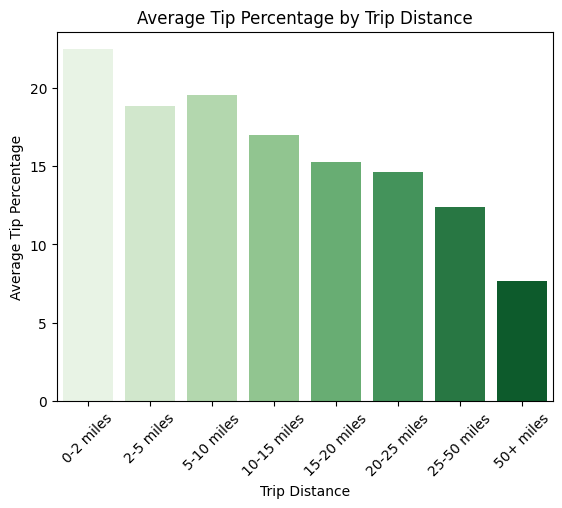

In [269]:
# Average Tip Percentage by Distance
bins = [0, 2, 5, 10, 15, 20, 25, 50, 100]
labels = ['0-2 miles', '2-5 miles', '5-10 miles', '10-15 miles', '15-20 miles', '20-25 miles', '25-50 miles', '50+ miles']
df['distance_group'] = pd.cut(df['trip_distance'], bins=bins, labels=labels, right=False)

avg_tip_distance = df.groupby('distance_group')['tip_percentage'].mean().reset_index()
sns.barplot(data=avg_tip_distance, x='distance_group', y='tip_percentage', palette='Greens')
plt.title('Average Tip Percentage by Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Average Tip Percentage')
plt.xticks(rotation=45)
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

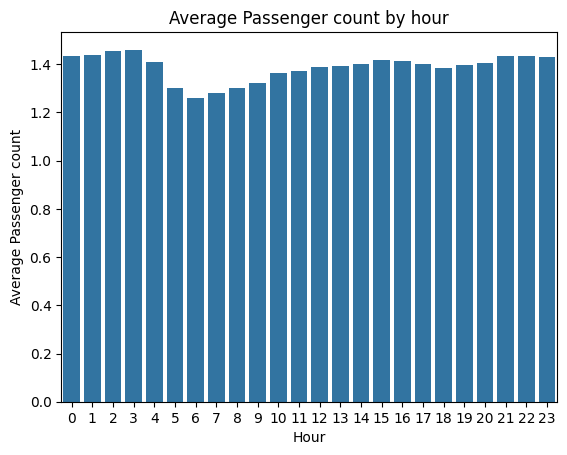

In [272]:
# See how passenger count varies across hours and days
passenger_count_hours = df.groupby(['tpep_pickup_hour']).agg(avg_passenger=('passenger_count', 'mean'))

sns.barplot(data=passenger_count_hours, x='tpep_pickup_hour', y='avg_passenger')
plt.title('Average Passenger count by hour')
plt.xlabel('Hour')
plt.ylabel('Average Passenger count')
plt.show()



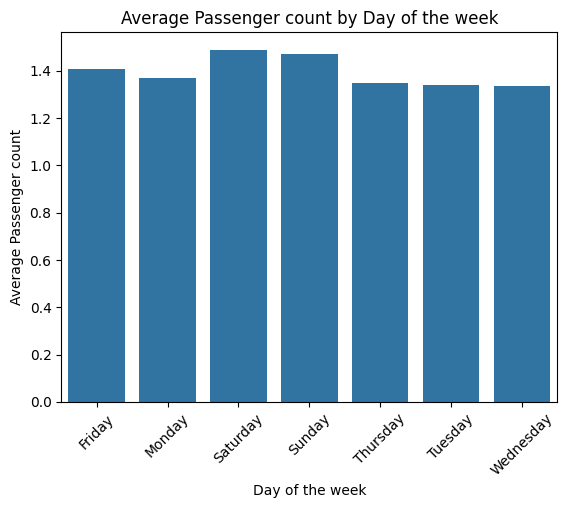

In [273]:
passenger_count_day = df.groupby(['tpep_pickup_dayofweek']).agg(
    avg_passenger=('passenger_count', 'mean')
)

sns.barplot(data=passenger_count_day, x='tpep_pickup_dayofweek', y='avg_passenger')
plt.title('Average Passenger count by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average Passenger count')
plt.xticks(rotation=45)
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

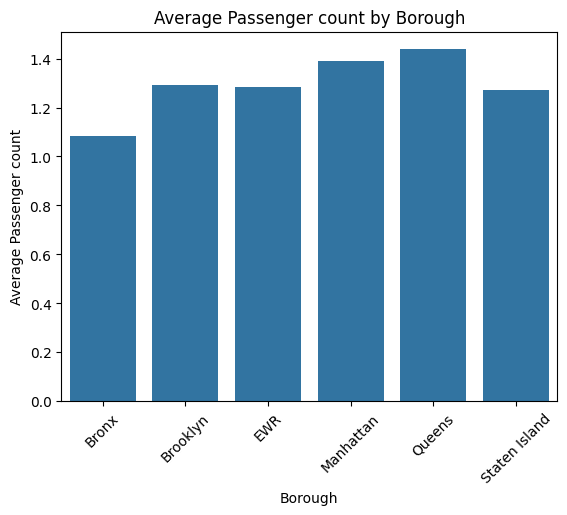

In [274]:
# How does passenger count vary across zones
borough_passenger_count = merged_df2.groupby(['borough_x']).agg(
    avg_passenger=('passenger_count', 'mean')
)

sns.barplot(data=borough_passenger_count, x='borough_x', y='avg_passenger')
plt.title('Average Passenger count by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Passenger count')
plt.xticks(rotation=45)
plt.show()


In [275]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
merged_df2['avg_pc_zone']=merged_df2.groupby('zone_x')['passenger_count'].transform('mean')


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [276]:
# How often is each surcharge applied?
print(f"Total Trips = {merged_df2.shape[0]}")
print(f"Total Trips with Extra charges = {(merged_df2[merged_df2.extra>0]).shape[0]}")
print(f"Total Trips with improvement surcharge = {(merged_df2[merged_df2.improvement_surcharge>0]).shape[0]}")
print(f"Total Trips with congestion surcharge = {(merged_df2[merged_df2.congestion_surcharge>0]).shape[0]}")


Total Trips = 1753215
Total Trips with Extra charges = 1082951
Total Trips with improvement surcharge = 1753185
Total Trips with congestion surcharge = 1636931


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

#### Dynamic Dispatching:
Implement a dynamic dispatching system that anticipates demand based on the hourly, daily, and monthly patterns identified. During peak hours (late afternoon/early evening on weekdays, potentially weekend nights), more cabs should be concentrated in high-demand zones.

#### Route Optimization:
Utilize the average speed analysis to identify historically slow routes. Dispatching systems can then avoid these routes during predicted congestion times or provide alternative routes to drivers. Providing real-time traffic information and route suggestions can also improve efficiency.

#### Focus on High-Volume Zones:
Prioritize cab allocation to the zones consistently showing high pickup and drop-off activity throughout the day and night.

#### Address Imbalances:
For zones with significant pickup/drop-off imbalances, implement strategies to reposition cabs efficiently. For zones with high pickups but low drop-offs, cabs should be directed to nearby high-demand drop-off zones. Conversely, for zones with high drop-offs but low pickups, cabs should be quickly repositioned to high-demand pickup areas.


**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

#### Hourly Positioning:
Cabs should be positioned in zones with historically high hourly pickups. For example, during morning commute hours, focus on residential areas and transport hubs. During business hours, concentrate on commercial districts. In the evening, shift focus to entertainment and dining areas

#### Weekend Positioning:
Adjust positioning strategies for weekends based on the distinct hourly patterns. Weekend demand might be more spread out or concentrated in entertainment and residential areas

#### Seasonal Adjustments:
Consider seasonal variations in demand (e.g., lower activity in summer months) when planning fleet size and positioning

#### Nighttime Strategy:
Ensure sufficient cab availability in night-time hot spots, which may differ significantly from daytime busy zones. This is crucial for capturing night revenue share.


**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

#### Dynamic Pricing:
Implement dynamic pricing strategies that adjust fares based on real-time demand and predicted congestion. Higher fares during peak hours and in high-demand zones can maximize revenue

#### Tiered Pricing Analysis:
Continue to monitor competitor pricing across different distance tiers. Adjust per-mile rates in specific tiers where the company's pricing might be significantly higher or lower than competitors, ensuring competitiveness

#### Surcharge Transparency:
Ensure transparency regarding surcharges to maintain customer trust. Analyze the impact of surcharges on overall revenue and customer satisfaction

#### Tipping Incentives:
Explore ways to encourage higher tipping through improved service quality, app-based tipping options, or driver incentives for positive customer feedback, especially for longer trips where tipping propensity is higher.

#### Analyze Fare per Mile by Passenger Count:
While fare is generally independent of passenger count, analyzing fare per mile per passenger provides insights into how the cost is distributed. This could potentially inform strategies for shared rides or larger vehicles if passenger count becomes a significant factor in future service offerings

By continuously monitoring these metrics and adapting strategies based on the evolving demand patterns and operational performance, taxi operations can be significantly optimized for efficiency, revenue, and customer satisfaction.
